
#**Deep Learning in Macroeconomics - MGS**

*The purpose of this project is to develop a predictive model to generate an expected yield curve of Malaysia Government Securities 10 years using deep learning method.* Source: https://www.youtube.com/watch?v=gSYiKKoREFI&t=526s

###**Import all functions -> Fire the System**

In [20]:
import numpy as np                                                                         #for numerical calculation
import pandas as pd                                                                        #for data structuring
import matplotlib.pyplot as plt                                                            #for data visualization
import datetime as dt                                                                      #for time manipulation
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard #For controlling training procedures

%matplotlib inline

###**Data Pre-processing**



In [21]:
from google.colab import drive                                            #Create path to google drive into google colab
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
#read data
path ="/content/drive/MyDrive/Master Project/MP2 - Dataset (New).xlsx"    #Define the path to data to be used in this project
df = pd.read_excel(path)                                                  #read the data using pandas function

df_date = df
df = df.astype(str)                                          

cols = list(df)[1:7]                                                              #Select the features(columns) in the dataset. Note that Column A=0, Column B=1 and etc
datelist_train = list(df['Date'])                                                   #Extract the dates to be used in visualization
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(df.shape))
print('All timestamps == {}'.format(len(df)))
print('Featured selected: {}'.format(cols))


Training set shape == (60, 8)
All timestamps == 60
Featured selected: ['MGS10 year (Yield %)', 'FBM KLCI (MoM Chg %)', 'Trade Balance (MoM Chg %)', 'Foreign Holding (MoM Chg %)', 'IP Index (YoY Chg %)', 'CPI (YoY Chg %)']


In [23]:
df = df[cols].astype(str)
for i in cols:
    for j in range(0, len(df)):
        df[i][j] = df[i][j].replace(',', '')                      #Although not necessary. This is to follow the method used by our reference. Source: https://github.com/vb100/multivariate-lstm/blob/master/LSTM_model_stocks.ipynb

df = df[cols].astype(float)                                       #Change the dataset into floating type (Note the dataset already in column)

training_set = df.values
print('Shape of training set == {}.'.format(training_set.shape))  #Change the dataset into matrix. Note that as_matrix() is already deprecated. use "Values"
training_set

Shape of training set == (60, 6).


array([[ 4.12400000e+00,  1.81576751e+00, -4.57079153e+01,
        -1.62644786e+00,  4.90000000e+00,  3.10000000e+00],
       [ 4.03700000e+00,  1.32991134e+00,  8.31827515e+01,
        -4.04332155e+00,  7.40000000e+00,  4.50000000e+00],
       [ 4.13400000e+00,  2.73472786e+00, -3.66550835e+01,
        -1.31857838e+01,  5.60000000e+00,  4.90000000e+00],
       [ 4.05200000e+00,  1.60738812e+00,  5.98478145e+01,
         3.87245956e+00,  6.50000000e+00,  4.30000000e+00],
       [ 3.87000000e+00, -1.23864575e-01, -3.08867486e+01,
         5.54989968e+00,  7.20000000e+00,  3.80000000e+00],
       [ 3.91000000e+00, -1.24584482e-01,  6.33189172e+01,
        -4.74943620e-01,  4.40000000e+00,  3.40000000e+00],
       [ 3.98800000e+00, -2.06387816e-01, -1.99882307e+01,
        -8.59451266e-01,  8.50000000e+00,  3.10000000e+00],
       [ 3.89200000e+00,  7.46010011e-01,  2.15003677e+01,
        -6.56613968e-01,  7.40000000e+00,  3.60000000e+00],
       [ 3.91700000e+00, -9.91450292e-01, -1.716

In [24]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[ 1.1561683 ],
       [ 0.98350219],
       [ 1.17601498],
       [ 1.01327221],
       [ 0.65206265],
       [ 0.73144937],
       [ 0.88625347],
       [ 0.69572534],
       [ 0.74534204],
       [ 0.70961802],
       [ 0.69771001],
       [ 0.72152603],
       [ 0.83266743],
       [ 0.96960952],
       [ 0.79694341],
       [ 1.16609164],
       [ 1.26334037],
       [ 1.30700307],
       [ 1.04105756],
       [ 0.98548686],
       [ 1.04105756],
       [ 1.06090424],
       [ 1.16807631],
       [ 1.04899624],
       [ 1.04899624],
       [ 0.69572534],
       [ 0.44764185],
       [ 0.49328921],
       [ 0.46748853],
       [ 0.17971168],
       [ 0.06063161],
       [-0.44744339],
       [-0.44744339],
       [-0.25691526],
       [-0.23508392],
       [-0.48713674],
       [-0.82056096],
       [-1.43183868],
       [-0.38591868],
       [-1.29092726],
       [-1.47947071],
       [-1.35840597],
       [-1.96571435],
       [-1.8327416 ],
       [-1.73350821],
       [-1

In [25]:
# Creating a data structure with 6 timestamps and 1 output (6 timestamps refers to 6 period)
X_train = []
y_train = []

n_future = 1   # Number of days we want top predict into the future
n_past = 6     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:df.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (54, 6, 5).
y_train shape == (54, 1).


###**Model Creation**



In [26]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [27]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=False, input_shape=(n_past, df.shape[1]-1))) #set 64 nodes for 1st layer #Change return_sequence to add layer

# Adding 2nd LSTM layer
#model.add(LSTM(units=6, return_sequences=False))                                     #set 10 nodes for 2nd layer - remove second layer

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error',metrics=["acc"])

In [28]:
%%time
epochs = 100
batch_size = 256

es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=epochs, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=batch_size)

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 1.1414 - acc: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.22160, saving model to weights.h5
1/1 [==============================] - 2s 2s/step - loss: 1.1414 - acc: 0.0000e+00 - val_loss: 0.2216 - val_acc: 0.0000e+00 - lr: 0.0100
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.5749 - acc: 0.0000e+00
Epoch 2: val_loss improved from 0.22160 to 0.18803, saving model to weights.h5
1/1 [==============================] - 0s 51ms/step - loss: 0.5749 - acc: 0.0000e+00 - val_loss: 0.1880 - val_acc: 0.0000e+00 - lr: 0.0100
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.2300 - acc: 0.0000e+00
Epoch 3: val_loss did not improve from 0.18803
1/1 [==============================] - 0s 39ms/step - loss: 0.2300 - acc: 0.0000e+00 - val_loss: 0.4568 - val_acc: 0.0000e+00 - lr: 0.0100
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.1862 - acc: 0.0000e+00
Epoch 4: val_los

# Make Predictions

In [11]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1m').tolist()

'''
The datelist 'datelist has been set from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [12]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [13]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['MGS10 year (Yield %)']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['MGS10 year (Yield %)']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head()

,MGS10 year (Yield %)
2018-01-31,3.853404
2018-02-28,3.957323
2018-03-31,4.084611
2018-04-30,4.096507
2018-05-31,4.213228


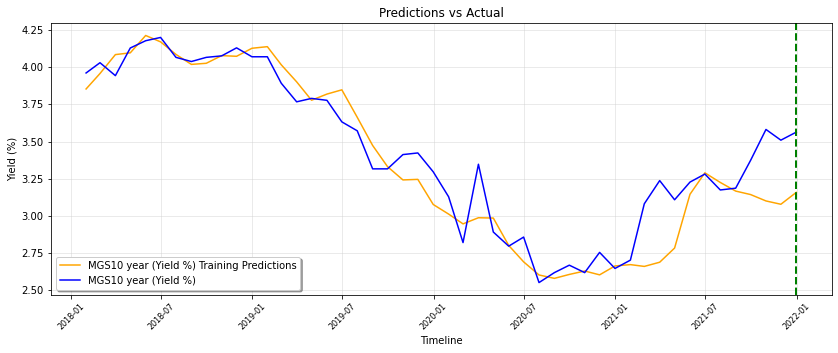

In [19]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

df_actual = (df_date.iloc[12:60])       #Resizing the actual dataset to match the predicted value

# Plot parameters
START_DATE_FOR_PLOTTING = '2018-01-31'

#plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['MGS10 year (Yield %)'], color='r', label='Predicted')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['MGS10 year (Yield %)'], color='orange', label='MGS10 year (Yield %) Training Predictions')
plt.plot(df_actual['Date'],df_actual['MGS10 year (Yield %)'], color='b', label='MGS10 year (Yield %)')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predictions vs Actual', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Yield (%)', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [15]:
df_days = df_actual.iloc[30:]
df_days.head(60)

,Date,MGS10 year (Yield %),FBM KLCI (MoM Chg %),Trade Balance (MoM Chg %),Foreign Holding (MoM Chg %),IP Index (YoY Chg %),CPI (YoY Chg %),UST10year (Yield %)
42,2020-07-31,2.551,6.847572,26.860874,4.402565,2.9,-1.3,0.5282
43,2020-08-31,2.618,-4.897272,-41.487845,1.651545,2.2,-1.4,0.7048
44,2020-09-30,2.668,-1.336865,48.426822,0.568525,4.3,-1.4,0.6840
45,2020-10-31,2.618,-2.520567,1.472465,3.351028,2.4,-1.5,0.8737
46,2020-11-30,2.754,6.532187,-23.154679,1.361921,2.0,-1.7,0.8389
47,2020-12-31,2.646,4.127445,21.198480,1.890354,4.1,-1.4,0.9132
48,2021-01-31,2.702,-3.737071,-19.912209,1.555209,3.5,-0.2,1.0655
49,2021-02-28,3.081,0.724591,7.673312,2.748277,4.5,0.1,1.4049
50,2021-03-31,3.237,-0.268737,35.391844,2.088210,12.7,1.7,1.7404
51,2021-04-30,3.108,1.788359,-15.885804,2.391499,68.0,4.7,1.6259


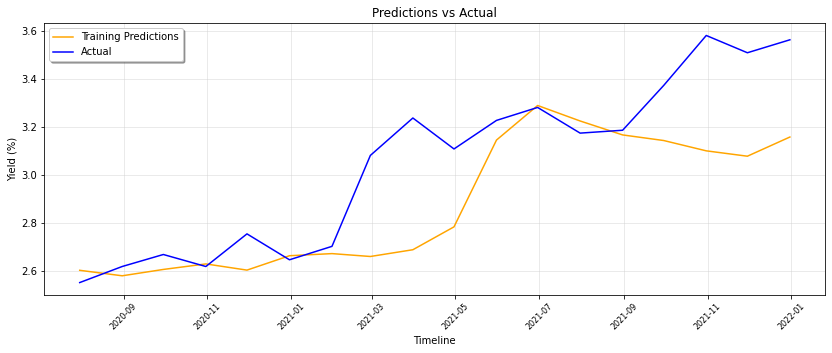

In [16]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

df_actual = (df_date.iloc[12:60])       #Resizing the actual dataset to match the predicted value

# Plot parameters
START_DATE_FOR_PLOTTING = '2020-07-31'

plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['MGS10 year (Yield %)'], color='orange', label='Training Predictions')
plt.plot(df_days['Date'],df_days['MGS10 year (Yield %)'], color='b', label='Actual')


plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predictions vs Actual', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Yield (%)', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [17]:
# calculate Model Evaluation
from sklearn.metrics import mean_absolute_error as mae

from statsmodels.tools.eval_measures import rmse, aic
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = round((sqrt(mean_squared_error(df_actual['MGS10 year (Yield %)'], PREDICTION_TRAIN))),4)
mae = round(mae(df_actual['MGS10 year (Yield %)'], PREDICTION_TRAIN),4)

print("Forecast Accuracy of (LSTM): MGS10 year ")
print("Mean absolute error : " + str(mae))
print('Test RMSE: %.3f' % rmse)

Forecast Accuracy of (LSTM): MGS10 year 
Mean absolute error : 0.1307
Test RMSE: 0.190


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# calculate RMSE
from statsmodels.tools.eval_measures import rmse, aic
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(df_actual['MGS10 year (Yield %)'], PREDICTION_TRAIN))


print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.172


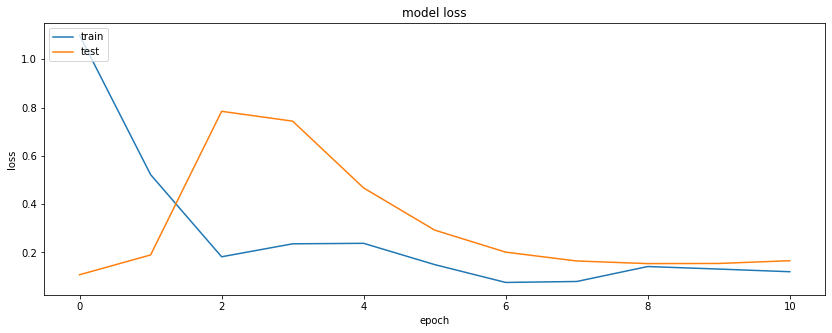

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

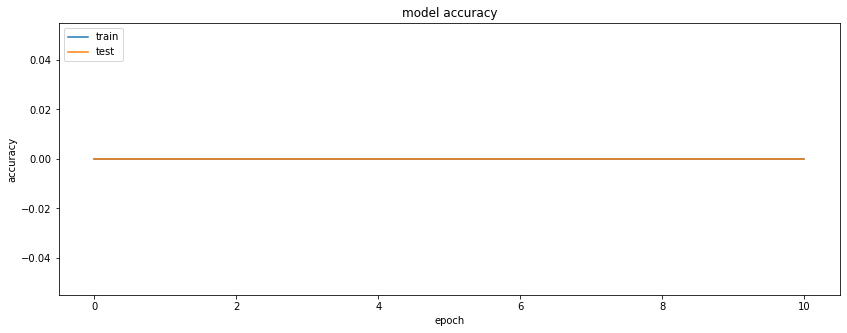

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17920     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
_________________________________________________________________


In [ ]:
PREDICTION_EVAL = PREDICTION_TRAIN.iloc[30:]
PREDICTION_EVAL.head(60)

,MGS10 year (Yield %)
2020-07-31,2.830225
2020-08-31,2.892085
2020-09-30,2.862845
2020-10-31,2.911896
2020-11-30,2.862661
2020-12-31,2.926470
2021-01-31,2.961394
2021-02-28,2.901499
2021-03-31,2.969016
2021-04-30,3.064922


In [ ]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(df, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(df.index)